# Use `Lale` `AIF360` scorers to calculate and mitigate bias for credit risk AutoAI model

This notebook contains the steps and code to demonstrate support of AutoAI experiments in Watson Machine Learning service. It introduces commands for bias detecting and mitigation performed with `lale.lib.aif360` module.

Some familiarity with Python is helpful. This notebook uses Python 3.7.

## Learning goals

The learning goals of this notebook are:

-  Work with Watson Machine Learning experiments to train AutoAI models.
-  Calculate fairness metrics of trained pipelines. 
-  Refine the best model and perform mitigation to get less biased model.
-  Store trained model with custom software specification.
-  Online deployment and score the trained model.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Optimizer definition](#definition)
3.	[Experiment Run](#run)
4.	[Pipeline bias detection and mitigation](#bias)
5.  [Deployment and score](#scoring)
6.  [Clean up](#cleanup)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

If you are not familiar with <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> and AutoAI experiments please read more about it in the sample notebook: <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd3.5/notebooks/python_sdk/experiments/autoai/Use%20AutoAI%20and%20Lale%20to%20predict%20credit%20risk.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI and Lale to predict credit risk with `ibm-watson-machine-learning`"</a>

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `password`.

In [1]:
username = 'PASTE YOUR USERNAME HERE'
password = 'PASTE YOUR PASSWORD HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
wml_credentials = {
    "username": username,
    "password": password,
    "url": url,
    "instance_id": 'openshift',
    "version": '3.5'
}

### Install and import the `ibm-watson-machine-learning`, `lale` and `aif360`.
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning | tail -n 1
!pip install -U scikit-learn==0.23.1 | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U lale | tail -n 1
!pip install -U aif360 | tail -n 1

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd3.5/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below


In [6]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.


In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [5]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## 2. Optimizer definition

### Training data connection

Define connection information to training data CSV file. This example uses the [German Credit Risk dataset](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/credit_risk_training_light.csv).

In [6]:
filename = 'german_credit_data_biased_training.csv'

Download training data from git repository and split for training and test set.

In [7]:
import os, wget
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd3.5/data/credit_risk/german_credit_data_biased_training.csv'
if not os.path.isfile(filename): wget.download(url)

credit_risk_df = pd.read_csv(filename)
X = credit_risk_df.drop(['Risk'], axis=1)
y = credit_risk_df['Risk']

credit_risk_df.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


Upload train dataset as Cloud Pack for Data data asset and define connection information to training data.


In [8]:
asset_details = client.data_assets.create(filename, filename)
asset_details

Creating data asset...
SUCCESS


{'metadata': {'space_id': '757f4731-bb33-48d9-a871-3fad5c16c954',
  'guid': '9f12244a-cb2d-4e39-ab76-c59f4a346f39',
  'href': '/v2/assets/9f12244a-cb2d-4e39-ab76-c59f4a346f39?space_id=757f4731-bb33-48d9-a871-3fad5c16c954',
  'asset_type': 'data_asset',
  'created_at': '2021-01-20T15:26:12Z',
  'last_updated_at': '2021-01-20T15:26:12Z'},
 'entity': {'data_asset': {'mime_type': 'text/csv'}}}

In [9]:
from ibm_watson_machine_learning.helpers import DataConnection, AssetLocation


credit_risk_conn = DataConnection(
    location=AssetLocation(asset_id=client.data_assets.get_id(asset_details)))

training_data_reference=[credit_risk_conn]

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric
- `daub_include_only_estimators` - estimators which will be included during AutoAI training. More available estimators can be found in `experiment.ClassificationAlgorithms` enum

In [10]:
from ibm_watson_machine_learning.experiment import AutoAI

experiment = AutoAI(wml_credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Bias detection in AutoAI',
    desc='Sample notebook',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
    daub_include_only_estimators=[experiment.ClassificationAlgorithms.XGB]    
)

<a id="run"></a>
## 3. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [11]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job d3b4eec2-b02f-410f-8f78-4c6666cd0dee completed: 100%|████████| [04:30<00:00,  2.70s/it]


In [12]:
pipeline_optimizer.get_run_status()

'completed'

You can list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame by calling the `summary()` method. 

In [13]:
summary = pipeline_optimizer.summary()
summary

,Number of enhancements,Estimator,training_roc_auc_(optimized),holdout_precision,training_average_precision,holdout_average_precision,training_neg_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,holdout_neg_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_4,3,XGBClassifierEstimator,0.853971,0.702532,0.786750,0.762646,-0.432601,0.664671,0.686865,0.794,0.761765,0.649368,0.683077,-0.434525,0.783778,0.858985,0.750276,0.667448
Pipeline_2,1,XGBClassifierEstimator,0.853223,0.674847,0.783110,0.759399,-0.437251,0.658683,0.674910,0.780,0.749762,0.657352,0.666667,-0.439138,0.779556,0.856000,0.749096,0.665831
Pipeline_3,2,XGBClassifierEstimator,0.853223,0.674847,0.783110,0.759399,-0.437251,0.658683,0.674910,0.780,0.749762,0.657352,0.666667,-0.439138,0.779556,0.856000,0.749096,0.665831
Pipeline_1,0,XGBClassifierEstimator,0.849883,0.692810,0.782921,0.760481,-0.437680,0.634731,0.692303,0.784,0.746795,0.638057,0.662500,-0.438008,0.783778,0.854903,0.747457,0.663639


### Get selected pipeline model

Download pipeline model object from the AutoAI training job.

In [15]:
best_pipeline = pipeline_optimizer.get_pipeline()

<a id="bias"></a>
## 4. Bias detection and mitigation

The `fairness_info` dictionary contains some fairness-related metadata. The favorable and unfavorable label are values of the target class column that indicate whether the loan was granted or denied. A protected attribute is a feature that partitions the population into groups whose outcome should have parity. The credit-risk dataset has two protected attribute columns, sex and age. Each prottected attributes has privileged and unprivileged group.

Note that to use fairness metrics from lale with numpy arrays `protected_attributes.feature` need to be passed as index of the column in dataset, not as name.

In [16]:
fairness_info = {'favorable_labels': ['No Risk'],
                 'protected_attributes': [
                     {'feature': credit_risk_df.columns.get_loc('Sex'),'privileged_groups': ['male']},
                     {'feature': credit_risk_df.columns.get_loc('Age'), 'privileged_groups': [[26, 40]]}]}
fairness_info

{'favorable_labels': ['No Risk'],
 'protected_attributes': [{'feature': 8, 'privileged_groups': ['male']},
  {'feature': 12, 'privileged_groups': [[26, 40]]}]}

### Calculate fairness metrics

We will calculate some model metrics. Accuracy describes how accurate is the model according to dataset. 
Disparate impact is defined by comparing outcomes between a privileged group and an unprivileged group, 
so it needs to check the protected attribute to determine group membership for the sample record at hand.
The third calculated metric takes the disparate impact into account along with accuracy. The best value of the score is 1.0.

In [19]:
import sklearn.metrics
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact

accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(best_pipeline, X.values, y.values):.1%}')
disparate_impact_scorer = disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(best_pipeline, X.values, y.values):.2f}')
combined_scorer = accuracy_and_disparate_impact(**fairness_info)
print(f'accuracy and disparate impact metric {combined_scorer(best_pipeline, X.values, y.values):.2f}')

accuracy 82.7%
disparate impact 0.71
accuracy and disparate impact metric 0.31


### Mitigation

`Hyperopt` minimizes (`best_score` - `score_returned_by_the_scorer`), where `best_score` is an argument to `Hyperopt` and `score_returned_by_the_scorer` is the value returned by the scorer for each evaluation point. We will use the `Hyperopt` to tune hyperparametres of the AutoAI pipeline to get new and more fair model. 


In [20]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale.lib.aif360 import FairStratifiedKFold
from lale import wrap_imported_operators

wrap_imported_operators()

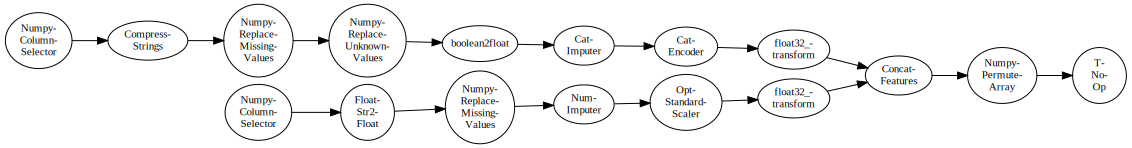

In [21]:
prefix = best_pipeline.remove_last().freeze_trainable()
prefix.visualize()

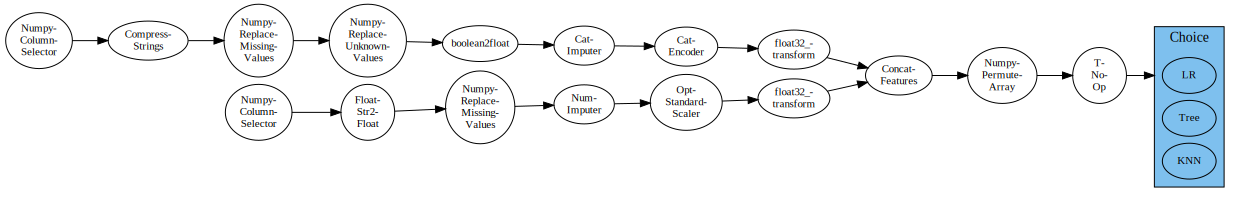

In [22]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

In [23]:
fair_cv = FairStratifiedKFold(**fairness_info, n_splits=3)

pipeline_fairer = new_pipeline.auto_configure(
    X.values, y, optimizer=Hyperopt, cv=fair_cv,
    max_evals=10, scoring=combined_scorer, best_score=1.0)

100%|██████████| 10/10 [01:45<00:00, 10.56s/trial, best loss: 0.27908105923458215]


As with any trained model, we can evaluate and visualize the result.

accuracy 74.2%
disparate impact 0.92
accuracy and disparate impact metric 0.74


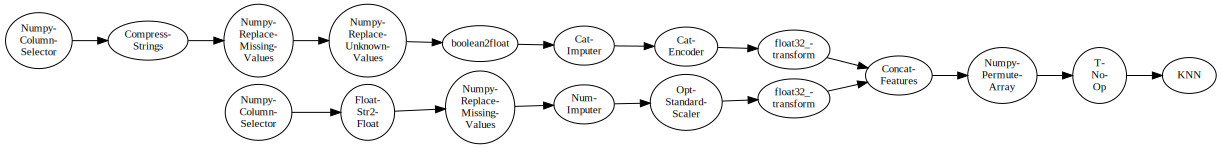

In [24]:
print(f'accuracy {accuracy_scorer(pipeline_fairer, X.values, y):.1%}')
print(f'disparate impact {disparate_impact_scorer(pipeline_fairer, X.values, y):.2f}')
print(f'accuracy and disparate impact metric {combined_scorer(pipeline_fairer, X.values, y.values):.2f}')
pipeline_fairer.visualize()

As the result demonstrates, the best model found by AI Automation
has lower accuracy and much better disparate impact as the one we saw
before. Also, it has tuned the repair level and
has picked and tuned a classifier. These results may vary by dataset and search space.

You can get source code of the created pipeline. You just need to change the below cell type `Raw NBCovert` to `code`.

<a id="scoring"></a>
## 5. Deploy and Score
In this section you will learn how to deploy and score Lale pipeline model using WML instance.

#### Custom software_specification

Created model is AutoAI model refined with Lale. We will create new software specification based on default Python 3.7 
environment extended by  `autoai-libs` package.

In [25]:
base_sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")
print("Id of default Python 3.7 software specification is: ", base_sw_spec_uid)

Id of default Python 3.7 software specification is:  e4429883-c883-42b6-87a8-f419d64088cd


In [26]:
url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd3.5/configs/config.yaml'
if not os.path.isfile('config.yaml'): wget.download(url)

In [27]:
!cat config.yaml

name: python37
channels:
  - defaults
dependencies:
  - pip:
    - autoai-libs

prefix: /opt/anaconda3/envs/python37

`config.yaml` file describes details of package extention. Now you need to store new package extention with  `APIClient`.

In [28]:
meta_prop_pkg_extn = {
    client.package_extensions.ConfigurationMetaNames.NAME: "Scikt with autoai-libs",
    client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "Pkg extension for autoai-libs",
    client.package_extensions.ConfigurationMetaNames.TYPE: "conda_yml"
}

pkg_extn_details = client.package_extensions.store(meta_props=meta_prop_pkg_extn, file_path="config.yaml")
pkg_extn_uid = client.package_extensions.get_uid(pkg_extn_details)
pkg_extn_url = client.package_extensions.get_href(pkg_extn_details)


Creating package extensions
SUCCESS


Create new software specification and add created package extention to it. 

In [29]:
meta_prop_sw_spec = {
    client.software_specifications.ConfigurationMetaNames.NAME: "Mitigated AutoAI bases on scikit spec",
    client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "Software specification for scikt with autoai-libs",
    client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {"guid": base_sw_spec_uid}
}

sw_spec_details = client.software_specifications.store(meta_props=meta_prop_sw_spec)
sw_spec_uid = client.software_specifications.get_uid(sw_spec_details)


status = client.software_specifications.add_package_extension(sw_spec_uid, pkg_extn_uid)

SUCCESS


You can get details of created software specification using `client.software_specifications.get_details(sw_spec_uid)`

### Store the model

In [30]:
model_props = {
    client.repository.ModelMetaNames.NAME: "Fairer AutoAI model",
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid
    
}
feature_vector = list(X.columns)

In [31]:
published_model = client.repository.store_model(
    model=best_pipeline.export_to_sklearn_pipeline(), 
    meta_props=model_props,
    training_data=X.values,
    training_target=y.values,
    feature_names=feature_vector,
    label_column_names=['Risk']
)

In [32]:
published_model_uid = client.repository.get_model_id(published_model)

### Deployment creation

In [33]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of fairer model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '04a8fed0-58e0-4167-aa65-6e9dce0534c0' started

#######################################################################################


initializing...............................................................................
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='42d072db-f877-49c0-9076-a2e7d61e6506'
------------------------------------------------------------------------------------------------




In [34]:
deployment_id = client.deployments.get_uid(created_deployment)

#### Deployment scoring 

You need to pass scoring values as input data if the deployed model. Use `client.deployments.score()` method to get predictions from deployed model. 

In [35]:
values = X.values

scoring_payload = {
    "input_data": [{
        'values': values[:5]
    }]
}

In [36]:
predictions = client.deployments.score(deployment_id, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.8288245797157288, 0.17117543518543243]],
    ['No Risk', [0.8916672468185425, 0.10833276063203812]],
    ['No Risk', [0.8854614496231079, 0.11453855037689209]],
    ['No Risk', [0.843461275100708, 0.1565387099981308]],
    ['No Risk', [0.8455864787101746, 0.15441352128982544]]]}]}

<a id="cleanup"></a>
## 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd3.5/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 7. Summary and next steps

 You successfully completed this notebook!.

Check out used packeges domuntations:
- `ibm-watson-machine-learning` [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)
- `lale`: https://github.com/IBM/lale
- `aif360`: https://aif360.mybluemix.net/

### Authors 

**Dorota Dydo-Rożniecka**, Intern in Watson Machine Learning at IBM

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.